<a href="https://colab.research.google.com/github/Alinka7/-NUMERICAL-SOLUTION-OF-DIFFERENTIAL-EQUATIONS-IN-PARTIAL-DERIVATIVES-/blob/main/Copy_of_part1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.transform import resize, rescale
from skimage.io import imread
import os
import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Common
import keras
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from numpy import zeros, random

# Data
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Data viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Dropout, BatchNormalization, Layer, Input, add, multiply, UpSampling2D

# Model Viz
from tensorflow.keras.utils import plot_model

# Callback
from keras.callbacks import Callback
from glob import glob
from numpy import zeros, random

In [4]:
# here I make normalization to move from the range 0-255 to 0-1.
# and cnahge the size of the input image: (255, 255) 
def load_image(path):
    img = resize(img_to_array(load_img(path))/255. , (256,256))
    return img

In [5]:
# here I make some preprocess for masks and images together:
# sort the orer of  masks
# change the name of masks
root_path = '/content/drive/MyDrive/Colab Notebooks/t/images/'
image_paths = sorted(glob(root_path + f"*.png"))
mask_paths = []
for path in image_paths:
    mask_path = path.replace('images','segmentations')
    mask_path = mask_path.replace('.png','_seg0.png')
    mask_paths.append(mask_path)
print(f"Total Number of Images  : {len(image_paths)}")

Total Number of Images  : 832


In [7]:
images = zeros(shape=(len(image_paths), 256, 256, 3)) # set the dimensions 
masks = zeros(shape=(len(image_paths), 256, 256, 3))
for n, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
    images[n] = load_image(img_path) # preprocess img using already created function
    masks[n] = load_image(mask_path) # preprocess img using already created function

Loading: 832it [00:57, 14.59it/s]


In [8]:
imagesTrain = images[:700] # the first 700 images to the train data
masksTrain = masks[:700] # the first 700 masks to the train data

imagesTest = images[700:] # the last 132 images to the test data
masksTest = masks[700:] # the last 132 masks to the test data

In [9]:
train = tf.convert_to_tensor(imagesTrain) # move from numpy array to tensor
train*=255 # move to the form of images 0-255 from 0-1
train = tf.dtypes.cast(train, tf.uint8) # change the data type to unit8

In [10]:
test = tf.convert_to_tensor(imagesTest) # move from numpy array to tensor
test*=255 # move to the form of images 0-255 from 0-1
test = tf.dtypes.cast(test, tf.uint8) # change the data type to unit8

In [12]:
@tf.function
# this function creates pairs of cropped images 
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data / 255,(128,128,3)),tf.float32) # crop a random part of image with the size (128, 128)
  lr=tf.image.resize(cropped,(64,64))
  lr=tf.image.resize(lr,(128,128), method = tf.image.ResizeMethod.BICUBIC) # here we move to low resolution image using bicubic interpolation
  return (lr,cropped) # as a result we have the following pair: (low res, high res)

# this function creates low resolution image using bicubic interpolation
def downsample_image(image,scale):
  lr=tf.image.resize(image / 255,(image.shape[0]//scale, image.shape[1]//scale)) # resizing to the correct size
  lr=tf.image.resize(lr,(image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC) # using bicubic interpolation
  return lr

In [ ]:
# Отже, використання num_parallel_calls=tf.data.AUTOTUNE
# дозволяє автоматично визначати кількість паралельних процесів,
# які потрібні для обробки даних у потоці tf.data.Dataset, що забезпечує
# максимальну швидкість обробки дани

In [13]:
# here I create tf.data.Dataset object which has pairs: (low res img, high res img)
# num_parallel_calls - numbers of parallel processes (increase the speed)
train_dataset_mapped =  tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset_mapped =  tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)

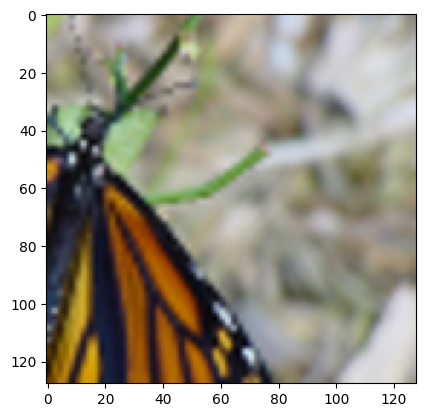

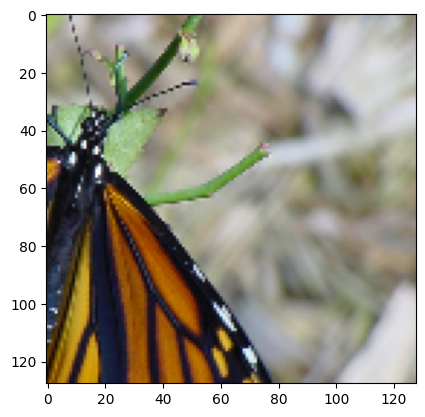

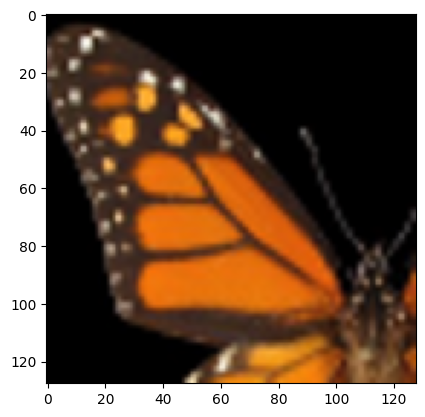

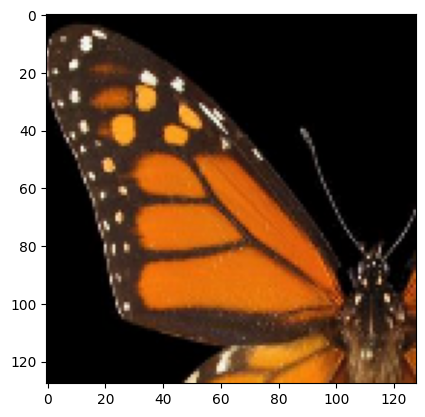

In [14]:
for x in train_dataset_mapped.take(2):
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [15]:
# creating model with architecture from article
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),  # number of filters = 64
                                                                    # layer performs convolution on the input image with a 9x9 kernel
                                                                    # add zeros to the edges of the input image so that the output image size is the same as the input size
                                                                    # functiion of activation = relu
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])

# it is a loss function, which is defined as MSE
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean((y_true - y_pred)**2)

# here I train the created model with the following paramaters:
# optimizer: Adam with learning reate 0.001
# loss function: MSE (which was created earlier)
SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [17]:
train_dataset_mapped = tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
val_dataset_mapped = tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
# use 20 epoch for training the model
# batch(128) - it groups the resulting dataset into batches of 128 samples.
# Batching the data helps to improve training efficiency by reducing the number of times the model needs to access memory during training.
SRCNN_915.fit(train_dataset_mapped,epochs=15,validation_data=val_dataset_mapped)

Epoch 1/15
6/6 [==============================] - 192s 28s/step - loss: 0.0053 - val_loss: 0.0048
Epoch 2/15
6/6 [==============================] - 170s 28s/step - loss: 0.0051 - val_loss: 0.0047
Epoch 3/15
6/6 [==============================] - 164s 27s/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/15
6/6 [==============================] - 170s 28s/step - loss: 0.0045 - val_loss: 0.0039
Epoch 5/15
6/6 [==============================] - 169s 28s/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/15
6/6 [==============================] - 165s 27s/step - loss: 0.0044 - val_loss: 0.0040
Epoch 7/15
6/6 [==============================] - 165s 27s/step - loss: 0.0043 - val_loss: 0.0051
Epoch 8/15
6/6 [==============================] - 164s 27s/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/15
6/6 [==============================] - 164s 27s/step - loss: 0.0047 - val_loss: 0.0039
Epoch 10/15
6/6 [==============================] - 164s 27s/step - loss: 0.0044 - val_loss: 0.0039
Epoch 11/15
6/6 [==

In [18]:
from skimage.metrics import peak_signal_noise_ratio


In [ ]:
# making the resulted vizualization
psnr_values = []
for x in tf.data.Dataset.from_tensor_slices(train).take(100):
  fig=plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  # plt.imshow(x.numpy()) # the input image
  plt.axis('off')
  plt.subplot(1,3,2)
  lr=downsample_image(x.numpy(),4)
  # plt.imshow(lr.numpy())  # bicubic interpolated image
  plt.axis('off')
  plt.subplot(1,3,3)
  pred=SRCNN_915(np.array([lr]))
  x = np.array(x, dtype=np.uint8)
  y = np.array(pred[0], dtype=np.uint8)
  psnr = peak_signal_noise_ratio(x, y)
  psnr_values.apend(psnr)
  # plt.imshow(tf.dtypes.cast(pred[0]*255, tf.uint8).numpy()) # super resolution image
  # plt.axis('off')
  # plt.show()

In [33]:
# making the resulted vizualization
psnr_values = []
for x in tf.data.Dataset.from_tensor_slices(train).take(100):
  lr=downsample_image(x.numpy(),4)
  pred=SRCNN_915(np.array([lr]))
  x = np.array(x, dtype=np.uint8)
  y = np.array(pred[0], dtype=np.uint8)
  psnr = peak_signal_noise_ratio(x, y)
  psnr_values.append(psnr)

In [34]:
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)

Average PSNR: 6.620314464942713
